<a href="https://colab.research.google.com/github/rtajeong/M1_2025/blob/main/Ch7_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 나이브 베이즈 분류기 실습

## 스팸 메일 분류

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 1. UCI SMS Spam Collection 데이터셋 로드 (URL에서 직접 로드)
# Colab 환경에서 편리하게 사용할 수 있는 공개된 raw GitHub URL이다.
# 원본 데이터는 탭으로 구분되어 있고, 헤더가 없음을 명시한다.
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'text'])


In [2]:
print("--- 원본 데이터셋 (상위 5개 행) ---")
print(df.head())

--- 원본 데이터셋 (상위 5개 행) ---
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
print("--- 데이터셋 정보 ---")
print(df.info())

--- 데이터셋 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [4]:
print("--- 레이블 분포 ---")
print(df['label'].value_counts())

--- 레이블 분포 ---
label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
# 레이블을 숫자로 변환 (ham: 0, spam: 1)
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

print("--- 인코딩된 레이블 데이터셋 (상위 5개 행) ---")
print(df.head())

--- 인코딩된 레이블 데이터셋 (상위 5개 행) ---
  label                                               text  label_encoded
0   ham  Go until jurong point, crazy.. Available only ...              0
1   ham                      Ok lar... Joking wif u oni...              0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...              1
3   ham  U dun say so early hor... U c already then say...              0
4   ham  Nah I don't think he goes to usf, he lives aro...              0


In [8]:
# 특성(X)과 레이블(y) 분리
X = df['text']
y = df['label_encoded']

# 훈련 세트와 테스트 세트로 분리 (80% 훈련, 20% 테스트)
# stratify=y는 레이블의 비율을 훈련/테스트 세트에서 원본 데이터와 동일하게 유지한다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- 데이터 분할 결과 ---")
print(f"훈련 데이터 개수: {len(X_train)}")
print(f"테스트 데이터 개수: {len(X_test)}")


--- 데이터 분할 결과 ---
훈련 데이터 개수: 4457
테스트 데이터 개수: 1115


In [9]:
print(f"훈련 세트 레이블 분포:\n{y_train.value_counts(normalize=True)}")
print(f"테스트 세트 레이블 분포:\n{y_test.value_counts(normalize=True)}")

훈련 세트 레이블 분포:
label_encoded
0    0.865829
1    0.134171
Name: proportion, dtype: float64
테스트 세트 레이블 분포:
label_encoded
0    0.866368
1    0.133632
Name: proportion, dtype: float64


In [10]:
# CountVectorizer를 사용하여 텍스트 데이터를 단어 빈도수로 변환 (BoW 모델)
# fit_transform은 훈련 데이터에 대한 단어 사전을 만들고 변환한다.
# transform은 테스트 데이터에 대해 훈련 데이터에서 만들어진 사전을 기반으로 변환한다.

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)   # fit() and transform()
X_test_counts = vectorizer.transform(X_test)         # transform() only

print("--- 텍스트 수치화 결과 (CountVectorizer) ---")
print("훈련 데이터 변환 형태:", X_train_counts.shape)
print("테스트 데이터 변환 형태:", X_test_counts.shape)


--- 텍스트 수치화 결과 (CountVectorizer) ---
훈련 데이터 변환 형태: (4457, 7668)
테스트 데이터 변환 형태: (1115, 7668)


In [13]:
X_train_counts, X_train_counts.toarray()

(<Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 58930 stored elements and shape (4457, 7668)>,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [14]:
# 어떤 단어들이 특성이 되었는지 상위 20개 확인
print(vectorizer.get_feature_names_out()[:20])


['00' '000' '000pes' '008704050406' '0089' '0121' '01223585236'
 '01223585334' '02' '0207' '02072069400' '02073162414' '02085076972' '021'
 '03' '04' '0430' '05' '050703' '0578']


In [16]:
# 나이브 베이즈 분류기 모델 생성 및 훈련
# MultinomialNB는 텍스트 분류와 같이 이산적인 카운트 데이터에 적합하다.
# alpha=1.0은 라플라스 스무딩을 적용하는 기본값이다. (특정 픽셀 패턴이 학습
# 데이터에 없더라도, smoothing을 통해 그 확률을 0이 아닌 작은 값으로 둔다)

model = MultinomialNB(alpha=1.0)
model.fit(X_train_counts, y_train)

MultinomialNB()

In [17]:
# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test_counts)

In [18]:
# 정확도 계산 및 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- 모델 예측 및 평가 결과 ---")
print(f"모델의 정확도: {accuracy:.4f}") # 소수점 넷째 자리까지 출력


--- 모델 예측 및 평가 결과 ---
모델의 정확도: 0.9874


In [20]:
# 더 상세한 분류 보고서 출력 (정밀도, 재현율, F1-점수 포함)

print("\n--- 분류 보고서 ---\n")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


--- 분류 보고서 ---

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.99      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



## 숫자 이미지 분류 (간략화된 MNIST)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits # 숫자 이미지 데이터셋 로드
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB # 연속형 데이터에 적합한 가우시안 나이브 베이즈
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터셋 로드 및 특성(X), 레이블(y) 분리
digits = load_digits()

X = digits.data  # 이미지 픽셀 데이터 (64개 특성)
y = digits.target # 숫자 레이블 (0-9)

print("--- 데이터셋 정보 ---")
print(f"이미지 데이터 형태 (X): {X.shape}")
print(f"레이블 데이터 형태 (y): {y.shape}\n")


--- 데이터셋 정보 ---
이미지 데이터 형태 (X): (1797, 64)
레이블 데이터 형태 (y): (1797,)



--- 첫 번째 이미지 시각화 ---


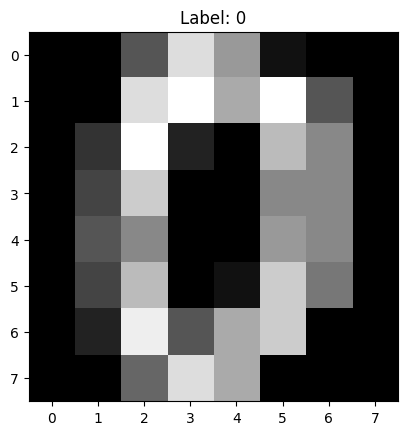

In [23]:
# 2. 이미지 시각화 (선택 사항: 데이터 확인용)
print("--- 첫 번째 이미지 시각화 ---")
plt.imshow(X[0].reshape(8, 8), cmap='gray') # 64개 픽셀을 8x8 이미지로 변환하여 표시
plt.title(f"Label: {y[0]}")
# plt.axis('off')
plt.show()

In [24]:
# 3. 데이터 분할 (훈련/테스트)
# stratify=y를 통해 각 숫자 클래스의 비율을 훈련/테스트 세트에서 균등하게 유지한다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- 데이터 분할 결과 ---")
print(f"훈련 데이터 개수: {len(X_train)}")
print(f"테스트 데이터 개수: {len(X_test)}\n")

--- 데이터 분할 결과 ---
훈련 데이터 개수: 1437
테스트 데이터 개수: 360



In [25]:
# 4. 모델 훈련 (Gaussian Naive Bayes)
# 픽셀 값은 연속형 데이터이므로 GaussianNB를 사용한다.
model_gaussian = GaussianNB()
model_gaussian.fit(X_train, y_train)


GaussianNB()

In [29]:
# 5. 모델 예측 및 성능 평가
y_pred_gaussian = model_gaussian.predict(X_test)
accuracy_gaussian = accuracy_score(y_test, y_pred_gaussian)

print(f"--- 모델 예측 및 평가 결과 ---")
print(f"모델의 정확도: {accuracy_gaussian:.4f}")

print("\n--- 분류 보고서 ---")
print(classification_report(y_test, y_pred_gaussian))

--- 모델 예측 및 평가 결과 ---
모델의 정확도: 0.8111

--- 분류 보고서 ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        36
           1       0.69      0.81      0.74        36
           2       0.83      0.54      0.66        35
           3       1.00      0.70      0.83        37
           4       0.96      0.72      0.83        36
           5       0.95      0.95      0.95        37
           6       0.95      0.97      0.96        36
           7       0.73      0.97      0.83        36
           8       0.50      0.83      0.62        35
           9       0.86      0.69      0.77        36

    accuracy                           0.81       360
   macro avg       0.85      0.81      0.81       360
weighted avg       0.85      0.81      0.82       360



- Multinomial NB 와 Gaussian NB
  - MNB:
    - 이산형(Discrete) 데이터, 주로 카운트 기반 (단어 빈도, 이벤트 발생 횟수 등)
    - 가정하는 분포: 다항분포(Multinomial distribution)
    - 적용: 텍스트 분류 (스팸 메일, 뉴스 카테고리 분류), 문서 분류, 단어 등장 횟수 기반 문제
    - 확률계산방식: 단어/특징의 등장 횟수를 기반으로 조건부 확률 계산
  - GNB:
    - 연속형(Continuous) 데이터, 주로 실수 값 (키, 몸무게, 센서 값 등)
    - 정규분포(Gaussian/Normal distribution) 가정
    - 적용: 연속형 피처가 많은 문제 (의학 데이터, 센서 데이터, 이미지 픽셀 값 등)
    - 확률계산방식: 각 특징이 클래스별로 정규분포를 따른다고 가정하고 평균·분산으로 확률 계산